## Home assignment.


In [1]:
import pandas as pd

We have put together the relevant utility functions we have developed so far in one python file called `adsl`, which we can now import.

In [2]:
from adsl import pd_read_dir, pd_read_json

#### Loads proposals and votes

_Note:_ adjust paths to files as needed for your system.

In [5]:
proposals = pd_read_json('../4_power/data/snapshot_proposals.json')

In [ ]:
# from adsl import gq, gql_all
# query = gq("snapshot_proposals", query_dir="../4_power/gql_queries/")
# res = await gql_all(query,
#                     field="proposals",
#                     first=1000,
#                     rest=True,
#                     save="proposals2.json")

In [4]:
votes = pd_read_dir('../4_power/data/votes/')

In [ ]:
# from adsl import gq, gql_all
# query = gq("snapshot_votes", query_dir="../4_power/gql_queries/")
# res = await gql_all(query,
#                     field="votes",
#                     save_interval=20,
#                     clear_on_save=True,
#                     first=20000,
#                     rest=True,
#                     save="votes.json",
#                     data_dir="data/votes/" ## Must exist.
# ) 

In [5]:
## Cleanup
votes['proposal'] = votes['proposal'].apply(lambda x :
                                            None if x is None else x['id'])

votes['space'] = votes['space'].apply(lambda x :
                                            None if x is None else x['id'])

votes['vp'] = votes['vp'].astype(float)

#### Some exploratory analysis

In [8]:
len(votes)
# proposals.groupby('id').count()

5494790

Let's check one proposal.

In [7]:
prop = "0x4a1aedbd9d22295f358dc4028b5a3f0a602bb5f1089dabdc2b63bf2bcce45834" 
## Ens space

In [8]:
prop_data = proposals[proposals['id'] == prop]
prop_data

,id,ipfs,author,created,space,network,symbol,type,strategies,plugins,...,snapshot,state,link,app,scores,scores_by_strategy,scores_state,scores_total,scores_updated,votes
66462,0x4a1aedbd9d22295f358dc4028b5a3f0a602bb5f1089d...,bafkreic2nbcusjm5umpifbinomvt3impewseprxz2dc23...,0x0904Dac3347eA47d208F3Fd67402D039a3b99859,1662678865,{'id': 'ens.eth'},1,ENS,basic,"[{'name': 'delegation', 'network': '1', 'param...",{},...,15499369,closed,https://snapshot.org/#/ens.eth/proposal/0x4a1a...,snapshot,"[2638265.201268065, 1379.7267441613, 11.868487...","[[12237.1500895823, 2626028.0511784824], [0, 1...",final,2639656.796499,1663110863,862


In [9]:
prop_data.columns

Index(['id', 'ipfs', 'author', 'created', 'space', 'network', 'symbol', 'type',
       'strategies', 'plugins', 'title', 'body', 'discussion', 'choices',
       'start', 'end', 'quorum', 'snapshot', 'state', 'link', 'app', 'scores',
       'scores_by_strategy', 'scores_state', 'scores_total', 'scores_updated',
       'votes'],
      dtype='object')

In [10]:
prop_data['discussion']

66462    https://discuss.ens.domains/t/rfp-ens-endowmen...
Name: discussion, dtype: object

In [16]:
prop_data['quorum']

66462    0.0
Name: quorum, dtype: float64

In [17]:
prop_data['snapshot']

66462    15499369
Name: snapshot, dtype: object

In [18]:
prop_data['scores']

66462    [2638265.201268065, 1379.7267441613, 11.868487...
Name: scores, dtype: object

In [19]:
prop_data['votes']

66462    862
Name: votes, dtype: int64

In [20]:
prop_data['choices']

66462    [For, Against, Abstain]
Name: choices, dtype: object

Let's get all votes for this proposal.

In [21]:
votes_one_prop = votes[votes['proposal'] == prop]
len(votes_one_prop)

862

In [22]:
votes_one_prop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862 entries, 29759 to 62798
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              862 non-null    object 
 1   ipfs            862 non-null    object 
 2   voter           862 non-null    object 
 3   created         862 non-null    int64  
 4   space           862 non-null    object 
 5   proposal        862 non-null    object 
 6   choice          862 non-null    object 
 7   metadata        862 non-null    object 
 8   reason          862 non-null    object 
 9   app             862 non-null    object 
 10  vp              862 non-null    float64
 11  vp_by_strategy  862 non-null    object 
 12  vp_state        862 non-null    object 
dtypes: float64(1), int64(1), object(11)
memory usage: 94.3+ KB


In [23]:
votes_one_prop['choice'].value_counts()

1    840
2     13
3      9
Name: choice, dtype: int64

In [26]:
votes_one_prop.groupby('choice')['vp'].sum()

choice
1    2.638265e+06
2    1.379727e+03
3    1.186849e+01
Name: vp, dtype: float64

Let's verify that they match the data in the proposals dataframe.

In [29]:
scores = votes_one_prop.groupby('choice')['vp'].sum()

a = list(scores)
b = list(prop_data['scores'])[0]

Perform element-wise comparison using the `zip` function. 


In [30]:
res = [True if i == j else False for i, j in zip(a, b) ]

Let's use the utility functions `all` and `any` to inspect the list.

In [36]:
def check_scores(res):    
    if all(res):
        print("_All_ score are equal")
    else:
        if any(res):
            print("_Some_ scores are equal")
        else:
            print("No score is equal")

In [37]:
check_scores(res)

_Some_ scores are equal


In [38]:
def almost_equal(a, b, t=0.01):
    return a-b < t

res = [True if almost_equal(i, j) else False for i, j in zip(a, b) ]

check_scores(res)

_All_ score are equal


We trust the data! Now let's continue.

#### Measuring approval rates of proposals.

To measure the "approval" rates of proposals we need to identify the "approve" choice among all the choices.

For this assignment, we look for proposals with choices like "Approve/Reject" and "For/Against/Abstain".


In [11]:
proposals['choices_len'] = proposals['choices'].apply(lambda x : len(x))

In [12]:
proposals['choices_len'].describe()

count    69266.000000
mean         2.961641
std          5.417321
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max        196.000000
Name: choices_len, dtype: float64

In [13]:
proposals = proposals.sort_values('choices_len', ascending=False)
proposals['choices'].head()

67298    [f-sdteth, f-sdcrvcrv, f-sdagag, f-sdfxsfxs, 2...
63992    [f-sdteth, f-sdcrvcrv, f-sdagag, f-sdfxsfxs, 2...
65654    [f-sdteth, f-sdcrvcrv, f-sdagag, f-sdfxsfxs, 2...
62257    [Chris Golden, Sam Young, Li Binglei, Kimbol, ...
62656    [Chris Golden, Bob Bicknell-Knight, Paul Kneal...
Name: choices, dtype: object

In [14]:
props = proposals[(proposals['choices_len'] > 1) & 
                  (proposals['choices_len'] < 4)]
len(props)

60152

In [15]:
props['choices_len'].value_counts()

2    48122
3    12030
Name: choices_len, dtype: int64

Pause and think: what are we missing with the above filter?

If you are done thinking, let's check what our filter caught.

['Great', 'Not bad', 'Sad']
['Yes', 'No', 'Abstain']
['Yes', 'No', 'Abstain']
['Yes', 'No', 'Abstain']
['Yes', 'No', 'Abstain']
['Yes', 'No', 'Abstain']
['会', '不会', '就是玩儿']
['Yes', 'No', 'Abstain']
['BNB', 'ETH', 'OTHER']
['Approve', 'Reject', 'Abstain']
['1000 TAUR', '2000 TAUR', '5000 TAUR']
['For', 'Against', 'Abstain']
['Yes', 'No', 'Abstain']
['For', 'Against', 'Abstain']
['For', 'Against', 'Abstain']
['Communication / branding ', 'Web3 and app development ', 'Set up tokenization processes']
['L2', 'corss brige', 'L1']
['big Investors', 'Good technology', 'Good business promotion']
['Yes', 'No', 'Abstain']
['FOR = Lower to 3M progressively', 'AGAINST = Keep 5M', 'ABSTAIN']
['For', 'Against', 'Abstain']
['For', 'Against', 'Abstain']
['+', '-', 'Invalid question/options']
['420 ohm minimum', '4.20 ohm minmum', '6.9 ohm minimum']
['a', 'b', 'c']
['Roulette - 1 Winner a month', 'Static, Distributed Evenly', 'Vote again']
['Yes', 'No', 'Abstain']
['For', 'Against', 'Abstain']
['Option 
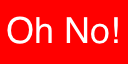
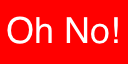

29858    None
29710    None
29711    None
29712    None
29713    None
         ... 
55094    None
45766    None
55095    None
55099    None
55092    None
Name: choices, Length: 60152, dtype: object

In [47]:
props['choices'].apply(lambda x : print(x))

In [48]:
def process_choices(x):
    return '_'.join(x).lower()

props['choices_str'] = props['choices'].apply(process_choices)


C:\Users\balistef\AppData\Local\Temp/ipykernel_14704/166396725.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  props['choices_str'] = props['choices'].apply(process_choices)


In [49]:
counts = props['choices_str'].value_counts()
for c, i in counts.items():
    print(c)

yes_no
for_against_abstain
for_against
1_2
会_不会
yes_no_abstain
y_n
approve_reject
agree_disagree
syes_ino
能_不能
a_b
有_没有
yes, let's do it_no, this is not the way
yes, accept report_no, report need to be improved
yes_no_invalid question/options
是_否
approve_deny
是_不是
同意_不同意
同意 agree_不同意 disagree
yes_no 
a_b_c
no_yes
yay_nay
accept_reject
approve_disapprove
yes _no
approve_decline
可以_不可以
1_2_3
option 1_option 2
in favor_against
approve_refuse
yes _no 
gogo_gogo
1_1
vote for_vote against
alice_bob_carol
test1_test2
si_no
yes_yes
approve_deny_abstain
yes_no_maybe
accept_decline
option 1_option 2_option 3
aye_nay
同意_反对
price up_price down
test_test
会_不会_不确定
support_reject
for_against_discuss more
will contact you_not now
支持_不支持
yes_no_not sure
是的_不是
1️⃣ _2️⃣ _3️⃣ 
syes_sno
pass_reject
yes_maybe
approve_do not approve
yes_red flag
支持_反对
ok_no
our vision at gurudao is to buil_our vision at gurudao is to buil
yes!_no!
🔥_👎
yea_nay
for_postpone: needs edits_against
i want this candidate to represe

Looked at the first most common sets of 2 and 3 options and manually eliminated obvious ones.

In [50]:
valid_choices = [
    "yes_no",
    "for_against_abstain",
    "for_against",
    "1_2",
    "会_不会",
    "yes_no_abstain",
    "y_n",
    "approve_reject",
    "agree_disagree",
    "syes_ino",
    "能_不能",
    # "a_b",
    "有_没有",
    "yes, let's do it_no, this is not the way",
    "yes_no_invalid question/options",
    "yes, accept report_no, report need to be improved",
    "是_否",
    "approve_deny",
    "是_不是",
    "同意_不同意",
    "同意 agree_不同意 disagree",
    "yes_no ",
    "a_b_c",
    # "no_yes",
    "yay_nay",
    "approve_disapprove",
    "accept_reject",
    "yes _no",
    "approve_decline",
    "可以_不可以",
    # "1_2_3",
    "option 1_option 2",
    "in favor_against",
    "approve_refuse",
    "yes _no ",
    # "gogo_gogo",
    # "1_1",
    "vote for_vote against",
    # "alice_bob_carol",
    # "test1_test2",
    "si_no",
    "approve_deny_abstain",
    "yes_yes",
    "yes_no_maybe",
    "accept_decline",
    # "option 1_option 2_option 3",
    "aye_nay",
    "同意_反对",
    # "price up_price down",
    # "test_test",
    "会_不会_不确定",
    "support_reject",
    "for_against_discuss more",
    "will contact you_not now",
    "支持_不支持",
    "yes_no_not sure",
    # "1️⃣ _2️⃣ _3️⃣ ",
    "是的_不是",
    "pass_reject",
    "syes_sno",
    "approve_do not approve",
    "yes_red flag",
    "yes_maybe",
    "ok_no",
    "支持_反对",
    # "our vision at gurudao is to buil_our vision at gurudao is to buil",
    "🔥_👎",
    "yes!_no!",
    "for_postpone: needs edits_against",
    "yea_nay",
    # "this proposal aims to define the_this proposal aims to define the",
    # "i want this candidate to represent $sushi_-",
    # "choice 1_choice 2",
    "yes, accept the proposal!_no, do not accept the proposal.",
    "yes_abstain_no",
    "approve_reject_abstain",
    # "test 1_test 2",
    "✅ yes, make the adjustments!_❌ no, don't make the adjustments!",
    "support_against",
    "oui_non",
    "yep_nope",
    # "2_3",
    # "one_two",
    "不会_会",
    "for _against",
    "list_do not list",
    # "clarified one line in the specif_clarified one line in the specif",
    "true_false",
    "agree_refuse",
    # "with the creation of any organiz_with the creation of any organiz",
    "支持_反对_弃权",
    "yes, approve the data source_no, dont approve the data source_abstain",
    "是的_没有",
    "好_不好",
    "support_not support",
    "賛成_反対",
    "yay_nay_abstain",
    "i agree_i disagree",
    # "btc_eth",
    "sim_não"
]


In [51]:
props['is_valid'] = props['choices_str'].isin(valid_choices)

C:\Users\balistef\AppData\Local\Temp/ipykernel_14704/2773712171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  props['is_valid'] = props['choices_str'].isin(valid_choices)


In [52]:
props['is_valid'].value_counts()

True     34830
False    25322
Name: is_valid, dtype: int64

In [53]:
valid_props = props[props['is_valid'] == True]


Now we have a collection of proposals for which we can identify the "approve" option.

Let's check whether those proposals have been approved.

In [54]:
def is_accepted(x):
    ## Some data issues still. To check.
    if len(x) == 0: return False

    ## Accepted score must be larger than second option.
    accepted_score = x[0]
    res = accepted_score > x[1]
    
    ## If there are 3 options, check if accepted 
    ## score is larger than the third option.
    if res and len(x) > 2:
        res = accepted_score > x[2]

    return res

In [55]:
valid_props['is_accepted'] = valid_props['scores'].apply(is_accepted)

C:\Users\balistef\AppData\Local\Temp/ipykernel_14704/1576594467.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_props['is_accepted'] = valid_props['scores'].apply(is_accepted)


In [56]:
valid_props['is_accepted'].value_counts()

True     21971
False    12859
Name: is_accepted, dtype: int64

In [57]:
groups = valid_props.groupby('is_accepted')
groups.first()

,id,ipfs,author,created,space,network,symbol,type,strategies,plugins,...,app,scores,scores_by_strategy,scores_state,scores_total,scores_updated,votes,choices_len,choices_str,is_valid
is_accepted,,,,,,,,,,,,,,,,,,,,,
False,0xbd1ff1faa80a340fc6523e033c49430b8349a13acb51...,QmQyQQQwuLx3x5jCG5ycYwUqjTGAdJj7ByAydnqLpBdcz6,0x873351e707257C28eC6fAB1ADbc850480f6e0633,1640084069,{'id': 'onout.eth'},56,,single-choice,"[{'name': 'erc20-balance-of', 'network': '56',...",{},...,,"[0, 0, 3347.318916477]","[[0], [0], [3347.318916477]]",final,3.347319e+03,1642503284,1,3,for_against_abstain,True
True,0xc8eba9c7fc64f10f182b6e859f252435df7c7f3583ef...,QmX6Uramq185ESYXwF9yn2uWuHmYkqwF2wbrutEMqBCmTZ,0x28C173B8F20488eEF1b0f48Df8453A2f59C38337,1640068764,{'id': 'jbdao.eth'},1,,single-choice,"[{'name': 'contract-call', 'network': '1', 'pa...",{},...,,"[72298756.77702612, 1291503.8185872, 0]","[[72298756.77702612], [1291503.8185872], [0]]",final,7.359026e+07,1640469632,14,3,yes_no_abstain,True


Let's plot the acceptance rate.

In [58]:
def acceptance_ratio(x):
    
    ## Data issues. Check.
    if type(x['scores']) == bool: return -1
    if len(x['scores']) == 0: return -1

    accepted = x['scores'][0]
    total = x['scores_total']

    # print(total, accepted)
    
    ## Data issues. Check.
    if total == 0 and accepted > 0: return -1
    if total == 0 and accepted == 0: return -1
    
    return accepted / total

valid_props['ratio'] = valid_props.apply(acceptance_ratio, axis=1)

C:\Users\balistef\AppData\Local\Temp/ipykernel_14704/3135243260.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_props['ratio'] = valid_props.apply(acceptance_ratio, axis=1)


In [59]:
valid_props['ratio'].describe()

count    34830.000000
mean         0.383003
std          0.823781
min         -1.000000
25%          0.000000
50%          0.951897
75%          1.000000
max          1.000000
Name: ratio, dtype: float64

is_accepted
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: ratio, dtype: object

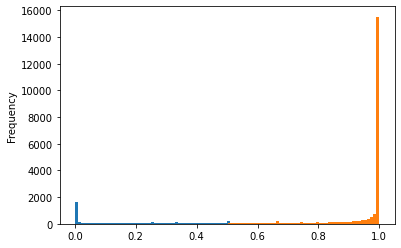

In [61]:
valid_props[valid_props['ratio'] != -1].sort_values('ratio').groupby('is_accepted')['ratio'].plot.hist(bins=100)

Did we do it right?

In [5]:
proposals['quorum'].value_counts()

0.0            63288
1.0             1588
10.0             451
1000.0           359
100.0            230
               ...  
126128286.7        1
25000000.0         1
6000000.0          1
7500000.0          1
8400000.0          1
Name: quorum, Length: 254, dtype: int64

#### Voter acceptance rate

In [62]:
valid_props_ids = valid_props['id']
len(valid_props_ids)

34830

In [63]:
valid_votes = votes[votes['proposal'].isin(valid_props_ids)]
len(valid_votes)

2532807

In [64]:
groups = valid_votes.groupby('voter')

In [68]:
voter_ratios = groups['choice'].aggregate(lambda x : sum(x == 1) / len(x))

<AxesSubplot:ylabel='Frequency'>

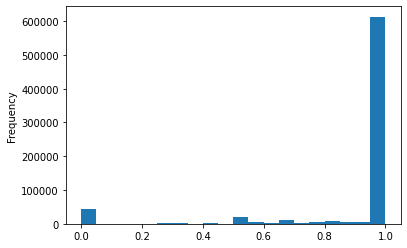

In [70]:
voter_ratios.plot.hist(bins=20)

<AxesSubplot:ylabel='Frequency'>

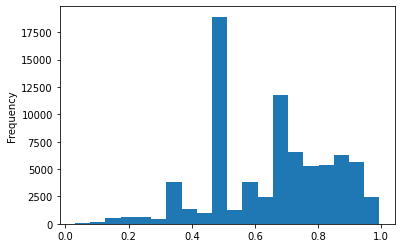

In [199]:
voter_ratios[(voter_ratios != 1) & (voter_ratios != 0)].plot.hist(bins=20)

#### Does the approval rate changes with experience?

In [72]:
votes_by_voter = valid_votes.value_counts('voter')

In [73]:
votes_by_voter

voter
0xd9293636EE3Aa663fc563ADB0912B0705dAfb62c    1580
0xC54A6C3778016b06cBD126cCc3B5Bc06c5F666fb     565
0x4d477F1aabcFc2FC3FC9b802E861C013E0123AD9     514
0x97432c12ea8C957C3aE2d59c9953CF8dF9CBc5b0     512
0xA8c4e3ce1743D0f2A6c227548C982a7C40569940     472
                                              ... 
0x85f6C09dB68273DE67B1da2F4De62e2B4397ec20       1
0x85f6976ABE8F0F48E0dB66A070B8664440Aa7f8E       1
0x85f653Bb4A1F744FFFDCFbF0a551dBC49457bC47       1
0x85f642d145313B23d3E2Ec6893823f0d4b33f201       1
0xfffd59651b59Eb34BdFfC11BFdB9DE67FA4167d2       1
Length: 733616, dtype: int64

In [74]:
voter_df = pd.concat([votes_by_voter, voter_ratios], axis=1)

In [77]:
voter_df.columns = ['nvotes', 'ratio']
voter_df.head()

,nvotes,ratio
voter,,
0xd9293636EE3Aa663fc563ADB0912B0705dAfb62c,1580,0.896835
0xC54A6C3778016b06cBD126cCc3B5Bc06c5F666fb,565,0.623009
0x4d477F1aabcFc2FC3FC9b802E861C013E0123AD9,514,0.914397
0x97432c12ea8C957C3aE2d59c9953CF8dF9CBc5b0,512,0.859375
0xA8c4e3ce1743D0f2A6c227548C982a7C40569940,472,0.936441


<AxesSubplot:xlabel='nvotes', ylabel='ratio'>

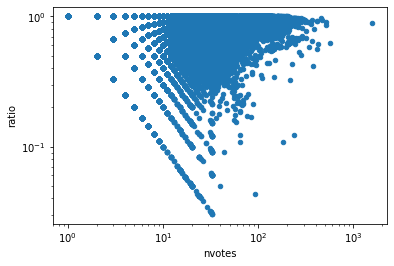

In [79]:
voter_df.plot.scatter('nvotes', 'ratio', loglog=True)